# Deep Q-Learning 

Install dependencies for AI gym to run properly (shouldn't take more than a minute). If running on google cloud or running locally, only need to run once. Colab may require installing everytime the vm shuts down.

In [1]:
# you will be prompted with a window asking to grant permissions
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
# fill in the path in your Google Drive in the string below. Note: do not escape slashes or spaces
import os
datadir = "/content/assignment5_materials"
if not os.path.exists(datadir):
  !ln -s "/content/drive/My Drive/CS444/assignment5_materials/" $datadir # TODO: Fill your A5 path
os.chdir(datadir)
!pwd

/content/drive/My Drive/CS444/assignment5_materials


In [3]:
!pip3 install gym pyvirtualdisplay
!sudo apt-get install -y xvfb python-opengl ffmpeg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:4.2.7-0ubuntu0.1).
The following additional packages will be installed:
  freeglut3 libfontenc1 libpython2-stdlib libxfont2 libxkbfile1 python2
  python2-minimal x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common
Suggested packages:
  python-tk python-numpy libgle3 python2-doc
The following NEW packages will be installed:
  freeglut3 libfontenc1 libpython2-stdlib libxfont2 libxkbfile1 python-opengl
  python2 python2-minimal x11-xkb-utils xfonts-base xfonts-encodings
  xfonts-utils xserver-common xvfb
0 upgraded, 14 newly installed, 0 to remove and 24 not upgraded.
Need to get 8,318 kB of archives.
After this operation, 18.0 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 python2-m

In [4]:
!pip3 install --upgrade setuptools --user
!pip3 install ez_setup 
!pip3 install gym[atari] 
!pip3 install gym[accept-rom-license] 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for ez_setup: filename=ez_setup-0.9-py3-none-any.whl size=11012 sha256=981a72488340c437566e59dff189f7187c7ee9f015fa71bd351809be4138b517
  Stored in directory: /root/.cache/pip/wheels/7a/d6/77/8f495e85fb7df23d41c328b9ea3cf0d9e83631b20bba479293
Successfully built ez_setup
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 9.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproj

For this assignment we will implement the Deep Q-Learning algorithm with Experience Replay as described in breakthrough paper __"Playing Atari with Deep Reinforcement Learning"__. We will train an agent to play the famous game of __Breakout__.

In [5]:
%matplotlib inline

import sys
import gym
import torch
import pylab
import random
import numpy as np
from collections import deque
from datetime import datetime
from copy import deepcopy
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from utils import find_max_lives, check_live, get_frame, get_init_state
from model import DQN
from config import *

import matplotlib.pyplot as plt
# %load_ext autoreload
# %autoreload 2

## Understanding the environment

In the following cell, we initialize our game of __Breakout__ and you can see how the environment looks like. For further documentation of the of the environment refer to https://www.gymlibrary.dev/environments/atari/breakout/. 

In breakout, we will use 3 actions "fire", "left", and "right". "fire" is only used to reset the game when a life is lost, "left" moves the agent left and "right" moves the agent right.

In [6]:
env = gym.make('BreakoutDeterministic-v4')
state = env.reset()

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [7]:
number_lives = find_max_lives(env)
state_size = env.observation_space.shape
action_size = 3 #fire, left, and right

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(


## Creating a DQN Agent

Here we create a DQN Agent. This agent is defined in the __agent.py__. The corresponding neural network is defined in the __model.py__. Once you've created a working DQN agent, use the code in agent.py to create a double DQN agent in __agent_double.py__. Set the flag "double_dqn" to True to train the double DQN agent.

__Evaluation Reward__ : The average reward received in the past 100 episodes/games.

__Frame__ : Number of frames processed in total.

__Memory Size__ : The current size of the replay memory.

In [8]:
double_dqn = False # set to True if using double DQN agent

if double_dqn:
    from agent_double import Agent
else:
    from agent import Agent

agent = Agent(action_size)
evaluation_reward = deque(maxlen=evaluation_reward_length)
frame = 0
memory_size = 0

### Main Training Loop

In this training loop, we do not render the screen because it slows down training signficantly. To watch the agent play the game, run the code in next section "Visualize Agent Performance"

episode: 0   score: 1.0   memory length: 172   epsilon: 1.0    steps: 172    lr: 0.0001     evaluation reward: 1.0
episode: 1   score: 4.0   memory length: 433   epsilon: 1.0    steps: 261    lr: 0.0001     evaluation reward: 2.5
episode: 2   score: 2.0   memory length: 650   epsilon: 1.0    steps: 217    lr: 0.0001     evaluation reward: 2.3333333333333335
episode: 3   score: 2.0   memory length: 849   epsilon: 1.0    steps: 199    lr: 0.0001     evaluation reward: 2.25
episode: 4   score: 0.0   memory length: 973   epsilon: 1.0    steps: 124    lr: 0.0001     evaluation reward: 1.8
episode: 5   score: 2.0   memory length: 1174   epsilon: 1.0    steps: 201    lr: 0.0001     evaluation reward: 1.8333333333333333
episode: 6   score: 0.0   memory length: 1297   epsilon: 1.0    steps: 123    lr: 0.0001     evaluation reward: 1.5714285714285714
episode: 7   score: 2.0   memory length: 1497   epsilon: 1.0    steps: 200    lr: 0.0001     evaluation reward: 1.625
episode: 8   score: 1.0   mem

/content/drive/MyDrive/CS444/assignment5_materials/memory.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sample = np.array(sample)
/content/drive/MyDrive/CS444/assignment5_materials/agent.py:59: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mini_batch = np.array(mini_batch).transpose()


episode: 544   score: 2.0   memory length: 100009   epsilon: 0.9999802000000004    steps: 199    lr: 0.0001     evaluation reward: 1.56
episode: 545   score: 2.0   memory length: 100208   epsilon: 0.999586180000009    steps: 199    lr: 0.0001     evaluation reward: 1.57
episode: 546   score: 0.0   memory length: 100332   epsilon: 0.9993406600000143    steps: 124    lr: 0.0001     evaluation reward: 1.55
episode: 547   score: 2.0   memory length: 100531   epsilon: 0.9989466400000229    steps: 199    lr: 0.0001     evaluation reward: 1.54
episode: 548   score: 1.0   memory length: 100701   epsilon: 0.9986100400000302    steps: 170    lr: 0.0001     evaluation reward: 1.53
episode: 549   score: 1.0   memory length: 100852   epsilon: 0.9983110600000367    steps: 151    lr: 0.0001     evaluation reward: 1.5
episode: 550   score: 4.0   memory length: 101154   epsilon: 0.9977131000000496    steps: 302    lr: 0.0001     evaluation reward: 1.53
episode: 551   score: 2.0   memory length: 101375 

KeyboardInterrupt: ignored

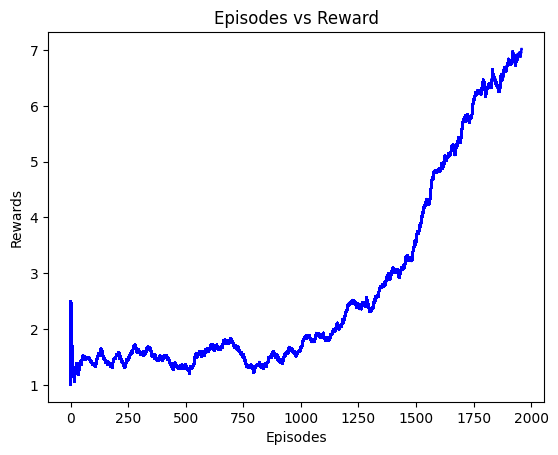

In [9]:
rewards, episodes = [], []
best_eval_reward = 0
for e in range(EPISODES):
    done = False
    score = 0

    history = np.zeros([5, 84, 84], dtype=np.uint8)
    step = 0
    state = env.reset()
    next_state = state
    life = number_lives

    get_init_state(history, state, HISTORY_SIZE)

    while not done:
        step += 1
        frame += 1

        # Perform a fire action if ball is no longer on screen to continue onto next life
        if step > 1 and len(np.unique(next_state[:189] == state[:189])) < 2:
            action = 0
        else:
            action = agent.get_action(np.float32(history[:4, :, :]) / 255.)
        state = next_state
        next_state, reward, done, info = env.step(action + 1)
        
        frame_next_state = get_frame(next_state)
        history[4, :, :] = frame_next_state
        terminal_state = check_live(life, info['lives'])

        life = info['lives']
        r = reward

        # Store the transition in memory 
        agent.memory.push(deepcopy(frame_next_state), action, r, terminal_state)
        # Start training after random sample generation
        if(frame >= train_frame):
            agent.train_policy_net(frame)
            # Update the target network only for Double DQN only
            if double_dqn and (frame % update_target_network_frequency)== 0:
                agent.update_target_net()
        score += reward
        history[:4, :, :] = history[1:, :, :]
            
        if done:
            evaluation_reward.append(score)
            rewards.append(np.mean(evaluation_reward))
            episodes.append(e)
            pylab.plot(episodes, rewards, 'b')
            pylab.xlabel('Episodes')
            pylab.ylabel('Rewards') 
            pylab.title('Episodes vs Reward')
            pylab.savefig("./save_graph/breakout_dqn.png") # save graph for training visualization
            
            # every episode, plot the play time
            print("episode:", e, "  score:", score, "  memory length:",
                  len(agent.memory), "  epsilon:", agent.epsilon, "   steps:", step,
                  "   lr:", agent.optimizer.param_groups[0]['lr'], "    evaluation reward:", np.mean(evaluation_reward))

            # if the mean of scores of last 100 episode is bigger than 5 save model
            ### Change this save condition to whatever you prefer ###
            if np.mean(evaluation_reward) > 5 and np.mean(evaluation_reward) > best_eval_reward:
                torch.save(agent.policy_net, "./save_model/breakout_dqn.pth")
                best_eval_reward = np.mean(evaluation_reward)


# Visualize Agent Performance

BE AWARE THIS CODE BELOW MAY CRASH THE KERNEL IF YOU RUN THE SAME CELL TWICE.

Please save your model before running this portion of the code.

In [10]:
torch.save(agent.policy_net, "./save_model/breakout_dqn_latest.pth")

In [11]:
from gym.wrappers import Monitor # If importing monitor raises issues, try using `from gym.wrappers import RecordVideo`
import glob
import io
import base64

from IPython.display import HTML
from IPython import display as ipythondisplay

from pyvirtualdisplay import Display

# Displaying the game live
def show_state(env, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("%s | Step: %d %s" % ("Agent Playing",step, info))
    plt.axis('off')

    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(plt.gcf())
    
# Recording the game and replaying the game afterwards
def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")
    

def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env

ImportError: ignored

In [ ]:
display = Display(visible=0, size=(300, 200))
display.start()

# Load agent
# agent.load_policy_net("./save_model/breakout_dqn.pth")
agent.epsilon = 0.0 # Set agent to only exploit the best action

env = gym.make('BreakoutDeterministic-v4')
env = wrap_env(env)

done = False
score = 0
step = 0
state = env.reset()
next_state = state
life = number_lives
history = np.zeros([5, 84, 84], dtype=np.uint8)
get_init_state(history, state)

while not done:
    
    # Render breakout
    env.render()
#     show_state(env,step) # uncommenting this provides another way to visualize the game

    step += 1
    frame += 1

    # Perform a fire action if ball is no longer on screen
    if step > 1 and len(np.unique(next_state[:189] == state[:189])) < 2:
        action = 0
    else:
        action = agent.get_action(np.float32(history[:4, :, :]) / 255.)
    state = next_state
    
    next_state, reward, done, info = env.step(action + 1)
        
    frame_next_state = get_frame(next_state)
    history[4, :, :] = frame_next_state
    terminal_state = check_live(life, info['ale.lives'])
        
    life = info['ale.lives']
    r = np.clip(reward, -1, 1) 
    r = reward

    # Store the transition in memory 
    agent.memory.push(deepcopy(frame_next_state), action, r, terminal_state)
    # Start training after random sample generation
    score += reward
    
    history[:4, :, :] = history[1:, :, :]
env.close()
show_video()
display.stop()